In [8]:
from typing import Optional
from qiskit.circuit.gate import Gate
from qiskit.circuit.parameterexpression import ParameterValueType
import numpy as np

class RiSwapGate(Gate):
    r"""RiSWAP gate.

    **Circuit Symbol:**

    .. parsed-literal::

        q_0: ─⨂─
           R(alpha)
        q_1: ─⨂─

    """

    def __init__(self, alpha: ParameterValueType, label: Optional[str] = None):
        """Create new iSwap gate."""
        super().__init__("riswap", 2, [alpha], label=label)

    def __array__(self, dtype=None):
        """Return a numpy.array for the RiSWAP gate."""
        alpha = self.params[0]
        return np.array(
            [
                [1, 0, 0, 0],
                [0, np.cos(np.pi * alpha / 2), 1j * np.sin(np.pi * alpha / 2), 0],
                [0, 1j * np.sin(np.pi * alpha / 2), np.cos(np.pi * alpha / 2), 0],
                [0, 0, 0, 1],
            ],
            dtype=dtype,
        )

In [10]:
#from Qiskits two_qubit_decomp #FIXME moving functions around still this won't need to be copied once SQiSwap inside of that same pass
import cmath
from qiskit.quantum_info.synthesis.two_qubit_decompose import *
import scipy.linalg as la

_ipx = np.array([[0, 1j], [1j, 0]], dtype=complex)
_ipy = np.array([[0, 1], [-1, 0]], dtype=complex)
_ipz = np.array([[1j, 0], [0, -1j]], dtype=complex)
_id = np.array([[1, 0], [0, 1]], dtype=complex)


def KAKDecomp(unitary_matrix, *, fidelity=(1.0 - 1.0e-9)):
    """Perform the Weyl chamber decomposition, and optionally choose a specialized subclass.

    The flip into the Weyl Chamber is described in B. Kraus and J. I. Cirac, Phys. Rev. A 63,
    062309 (2001).

    FIXME: There's a cleaner-seeming method based on choosing branch cuts carefully, in Andrew
    M. Childs, Henry L. Haselgrove, and Michael A. Nielsen, Phys. Rev. A 68, 052311, but I
    wasn't able to get that to work.

    The overall decomposition scheme is taken from Drury and Love, arXiv:0806.4015 [quant-ph].
    """
    pi = np.pi
    pi2 = np.pi / 2
    pi4 = np.pi / 4

    # Make U be in SU(4)
    U = np.array(unitary_matrix, dtype=complex, copy=True)
    detU = la.det(U)
    U *= detU ** (-0.25)
    global_phase = cmath.phase(detU) / 4

    Up = transform_to_magic_basis(U, reverse=True)
    M2 = Up.T.dot(Up)

    # M2 is a symmetric complex matrix. We need to decompose it as M2 = P D P^T where
    # P ∈ SO(4), D is diagonal with unit-magnitude elements.
    #
    # We can't use raw `eig` directly because it isn't guaranteed to give us real or othogonal
    # eigenvectors.  Instead, since `M2` is complex-symmetric,
    #   M2 = A + iB
    # for real-symmetric `A` and `B`, and as
    #   M2^+ @ M2 = A^2 + B^2 + i [A, B] = 1
    # we must have `A` and `B` commute, and consequently they are simultaneously diagonalizable.
    # Mixing them together _should_ account for any degeneracy problems, but it's not
    # guaranteed, so we repeat it a little bit.  The fixed seed is to make failures
    # deterministic; the value is not important.
    state = np.random.default_rng(2020)
    for _ in range(100):  # FIXME: this randomized algorithm is horrendous
        M2real = state.normal() * M2.real + state.normal() * M2.imag
        _, P = np.linalg.eigh(M2real)
        D = P.T.dot(M2).dot(P).diagonal()
        if np.allclose(P.dot(np.diag(D)).dot(P.T), M2, rtol=0, atol=1.0e-13):
            break
    else:
        raise ValueError

    d = -np.angle(D) / 2
    d[3] = -d[0] - d[1] - d[2]
    cs = np.mod((d[:3] + d[3]) / 2, 2 * np.pi)

    # Reorder the eigenvalues to get in the Weyl chamber
    cstemp = np.mod(cs, pi2)
    np.minimum(cstemp, pi2 - cstemp, cstemp)
    order = np.argsort(cstemp)[[1, 2, 0]]
    cs = cs[order]
    d[:3] = d[order]
    P[:, :3] = P[:, order]

    # Fix the sign of P to be in SO(4)
    if np.real(la.det(P)) < 0:
        P[:, -1] = -P[:, -1]

    # Find K1, K2 so that U = K1.A.K2, with K being product of single-qubit unitaries
    K1 = transform_to_magic_basis(Up @ P @ np.diag(np.exp(1j * d)))
    K2 = transform_to_magic_basis(P.T)

    K1l, K1r, phase_l = decompose_two_qubit_product_gate(K1)
    K2l, K2r, phase_r = decompose_two_qubit_product_gate(K2)
    global_phase += phase_l + phase_r

    K1l = K1l.copy()

    # Flip into Weyl chamber
    if cs[0] > pi2:
        cs[0] -= 3 * pi2
        K1l = K1l.dot(_ipy)
        K1r = K1r.dot(_ipy)
        global_phase += pi2
    if cs[1] > pi2:
        cs[1] -= 3 * pi2
        K1l = K1l.dot(_ipx)
        K1r = K1r.dot(_ipx)
        global_phase += pi2
    conjs = 0
    if cs[0] > pi4:
        cs[0] = pi2 - cs[0]
        K1l = K1l.dot(_ipy)
        K2r = _ipy.dot(K2r)
        conjs += 1
        global_phase -= pi2
    if cs[1] > pi4:
        cs[1] = pi2 - cs[1]
        K1l = K1l.dot(_ipx)
        K2r = _ipx.dot(K2r)
        conjs += 1
        global_phase += pi2
        if conjs == 1:
            global_phase -= pi
    if cs[2] > pi2:
        cs[2] -= 3 * pi2
        K1l = K1l.dot(_ipz)
        K1r = K1r.dot(_ipz)
        global_phase += pi2
        if conjs == 1:
            global_phase -= pi
    if conjs == 1:
        cs[2] = pi2 - cs[2]
        K1l = K1l.dot(_ipz)
        K2r = _ipz.dot(K2r)
        global_phase += pi2
    if cs[2] > pi4:
        cs[2] -= pi2
        K1l = K1l.dot(_ipz)
        K1r = K1r.dot(_ipz)
        global_phase -= pi2

    a, b, c = cs[1], cs[0], cs[2]
    return global_phase, (a, b, c), K1l, K1r, K2l, K2r

In [54]:
# Reference: https://arxiv.org/pdf/2105.06074.pdf
from qiskit.circuit.library import RZGate, RXGate, RYGate, IGate
from qiskit.extensions.unitary import UnitaryGate
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
# from utils.riswap_gates.riswap import RiSwapGate

def decomp(U):
    """Decompose U into single qubit gates and the SQiSW gates"""
    qc = QuantumCircuit(2)

    _, (x, y, z), A1, A2, B1, B2 = KAKDecomp(U)
    if np.abs(z) <= x - y:
        C1, C2 = interleavingSingleQubitRotations(x, y, z)
        V = RiSwapGate(0.5).to_matrix() @ np.kron(C1, C2) @ RiSwapGate(0.5).to_matrix()
        _, (x, y, z), D1, D2, E1, E2 = KAKDecomp(V)

        qc.append(UnitaryGate(np.matrix(E1).H @ B1), [1])
        qc.append(UnitaryGate(np.matrix(E2).H @ B2), [0])
        qc.append(RiSwapGate(0.5), [0, 1])
        qc.append(UnitaryGate(C1), [1])
        qc.append(UnitaryGate(C2), [0])
        qc.append(RiSwapGate(0.5), [0, 1])
        qc.append(UnitaryGate(A1 @ np.matrix(D1).H), [1])
        qc.append(UnitaryGate(A2 @ np.matrix(D2).H), [0])
    else:
        (x, y, z), F1, F2, G1, G2, H1, H2 = canonicalize(x, y, z)
        C1, C2 = interleavingSingleQubitRotations(x, y, z)
        V = RiSwapGate(0.5).to_matrix() @ np.kron(C1, C2) @ RiSwapGate(0.5).to_matrix()
        _, (x, y, z), D1, D2, E1, E2 = KAKDecomp(V)

        qc.append(UnitaryGate(H1 @ B1), [1])
        qc.append(UnitaryGate(H2 @ B2), [0])
        qc.append(RiSwapGate(0.5), [0, 1])
        qc.append(UnitaryGate(np.matrix(E1).H @ G1), [1])
        qc.append(UnitaryGate(np.matrix(E2).H @ G2), [0])
        qc.append(RiSwapGate(0.5), [0, 1])
        qc.append(UnitaryGate(C1), [1])
        qc.append(UnitaryGate(C2), [0])
        qc.append(RiSwapGate(0.5), [0, 1])
        qc.append(UnitaryGate(A1 @ F1 @ np.matrix(D1).H), [1])
        qc.append(UnitaryGate(A2 @ F2 @ np.matrix(D2).H), [0])

    return qc


def interleavingSingleQubitRotations(x, y, z):
    """Output the single qubit rotations given the interaction coefficients (x,y,z) \in W' when sandiwched by two SQiSW gates"""
    C = np.sin(x + y - z) * np.sin(x - y + z) * np.sin(-x - y - z) * np.sin(-x + y + z)
    alpha = np.arccos(np.cos(2 * x) - np.cos(2 * y) + np.cos(2 * z) + 2 * np.sqrt(C))
    beta = np.arccos(np.cos(2 * x) - np.cos(2 * y) + np.cos(2 * z) - 2 * np.sqrt(C))
    _num = 4 * (np.cos(x) ** 2) * (np.cos(z) ** 2) * (np.cos(y) ** 2)
    _den = _num + np.cos(2 * x) + np.cos(2 * y) * np.cos(2 * z)
    gamma = np.arccos(np.sign(z) * np.sqrt(_num / _den))
    return (
        RZGate(gamma).to_matrix()
        @ RXGate(alpha).to_matrix()
        @ RZGate(gamma).to_matrix(),
        RXGate(beta).to_matrix(),
    )


def canonicalize(x, y, z):
    """Decompose an arbitrary gate into one SQISW and one L(x,y',z) where (x',y',z') \in W' and output the coefficients (x',y',z') and the interleaving single qubit rotations"""
    A1 = IGate().to_matrix()
    A2 = IGate().to_matrix()
    B1 = RYGate(-np.pi / 2).to_matrix()
    B2 = RYGate(np.pi / 2).to_matrix()
    C1 = RYGate(np.pi / 2).to_matrix()
    C2 = RYGate(-np.pi / 2).to_matrix()
    s = np.sign(z)
    z = np.abs(z)
    if x > np.pi / 8:
        y = y - np.pi / 8
        z = z - np.pi / 8
        B1 = RZGate(np.pi / 2).to_matrix() @ B1
        B2 = RZGate(-np.pi / 2).to_matrix() @ B2
        C1 = C1 @ RZGate(-np.pi / 2).to_matrix()
        C2 = C2 @ RZGate(np.pi / 2).to_matrix()

    else:
        x = x + np.pi / 8
        z = z - np.pi / 8

    if np.abs(y) < np.abs(z):
        # XXX typo in alibaba here (?)
        z = -z
        A1 = RXGate(np.pi / 2).to_matrix()
        A2 = RXGate(-np.pi / 2).to_matrix()
        B1 = RXGate(-np.pi / 2).to_matrix() @ B1
        B2 = RXGate(np.pi / 2).to_matrix() @ B2
    if s < 0:
        z = -z
        A1 = RZGate(np.pi).to_matrix() @ A1 @ RZGate(np.pi).to_matrix()
        B1 = RZGate(np.pi).to_matrix() @ B1 @ RZGate(np.pi).to_matrix()
        C1 = RZGate(np.pi).to_matrix() @ C1 @ RZGate(np.pi).to_matrix()
    
    return (x,y,z), A1, A2, B1, B2, C1, C2

## Verify

In [57]:
qc = QuantumCircuit(2)
qc.iswap(0,1)
new_qc = decomp(Operator(qc).data)
Operator(new_qc).equiv(qc)

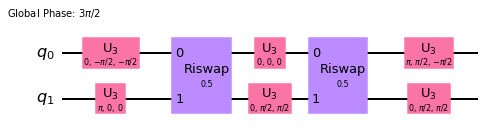

In [56]:
new_qc.decompose().draw(output='mpl')

## Basic pass manager

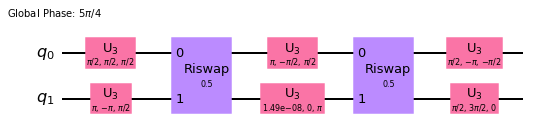

In [33]:
from qiskit.transpiler import PassManager
pm = PassManager()
from qiskit.transpiler.passes import (
    BasisTranslator,
    UnrollCustomDefinitions,
    Optimize1qGates,
    Optimize1qGatesDecomposition,
    Optimize1qGatesSimpleCommutation
)
from qiskit.transpiler import PassManager
from qiskit.circuit.equivalence_library import StandardEquivalenceLibrary as _sel

pass_ = [UnrollCustomDefinitions(_sel, ["u3", "riswap"]), Optimize1qGatesDecomposition(basis=["u3, riswap"])]
pm = PassManager(pass_)
new_circ = pm.run(new_qc)
new_circ.draw(output="mpl")

## Verify again

In [35]:
decomposer = OneQubitEulerDecomposer("ZSXX")
decomposer(new_qc)


/home/evm9/transpilation_EM/venv/lib/python3.8/site-packages/qiskit/quantum_info/synthesis/one_qubit_decompose.py:157: FutureWarning: The input object of type 'UnitaryGate' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'UnitaryGate', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unitary = np.asarray(unitary, dtype=complex)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (8, 3) + inhomogeneous part.

In [34]:
Operator(new_circ).equiv(CXGate())

True